<a href="https://colab.research.google.com/github/Adilalahee/ImmersiveAI-Colab-DataHub/blob/main/ECG_Train_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Import Google Drive to access the dataset stored in the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from tensorflow.keras import models, layers
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import matplotlib.pyplot as plt

In [4]:
# Load datasets
train_data = pd.read_csv('/content/drive/MyDrive/Mydrive/Stu/mitbih_train.csv', header=None)
test_data = pd.read_csv('/content/drive/MyDrive/Mydrive/Stu/mitbih_test.csv', header=None)

# Separate features and labels
X_train = train_data.iloc[:, :-1].values  # 187 features
y_train = train_data.iloc[:, -1].values   # Last column (labels)
X_test = test_data.iloc[:, :-1].values
y_test = test_data.iloc[:, -1].values

# Convert labels to integers
y_train = y_train.astype(int)
y_test = y_test.astype(int)

# Check original class distribution
original_counts = np.bincount(y_train)
print("Original training class distribution:", dict(enumerate(original_counts)))

# Define sampling strategy (must be >= original counts)
sampling_strategy = {
    0: 72471,  # Match exact count or increase (e.g., 75000)
    1: 20000,  # Oversample from 2223
    2: 5788,   # Match exact count or increase (e.g., 6000)
    3: 20000,  # Oversample from 641
    4: 6431    # Match exact count or increase (e.g., 7000)
}

# Oversample with SMOTE
X_train_flat = X_train.reshape(X_train.shape[0], -1)
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_flat, y_train)

# Normalize
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_resampled)
X_test = scaler.transform(X_test.reshape(X_test.shape[0], -1))

# Reshape for CNN
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Convert labels to categorical
num_classes = 5
y_train = to_categorical(y_train_resampled, num_classes)
y_test = to_categorical(y_test, num_classes)

print("New training set shape:", X_train.shape)
print("New class distribution:", np.bincount(y_train_resampled))

Original training class distribution: {0: 72471, 1: 2223, 2: 5788, 3: 641, 4: 6431}
New training set shape: (124690, 187, 1)
New class distribution: [72471 20000  5788 20000  6431]


In [5]:
model = models.Sequential([
    layers.Conv1D(128, kernel_size=6, activation='relu', input_shape=(X_train.shape[1], 1), padding='same'),
    layers.BatchNormalization(),
    layers.Conv1D(128, kernel_size=6, activation='relu', padding='same'),
    layers.MaxPooling1D(pool_size=3),
    layers.Conv1D(256, kernel_size=6, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv1D(256, kernel_size=6, activation='relu', padding='same'),
    layers.MaxPooling1D(pool_size=3),
    layers.Conv1D(512, kernel_size=6, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.GlobalAveragePooling1D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 187, 128)            │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 187, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 187, 128)            │          98,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 62, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 62, 256)             │         196,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 62, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 62, 256)             │         393,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 20, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, 20, 512)             │         786,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 20, 512)             │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,612,805 (6.15 MB)

 Trainable params: 1,611,013 (6.15 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [6]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_resampled),
    y=y_train_resampled
)
class_weight_dict = dict(enumerate(class_weights))
class_weight_dict[1] *= 1.2  # Boost class 1
class_weight_dict[3] *= 1.2  # Boost class 3

print("Class weights:", class_weight_dict)

Class weights: {0: 0.34411005781622994, 1: 1.4962799999999998, 2: 4.308569454042847, 3: 1.4962799999999998, 4: 3.8777795055201367}


In [7]:
history = model.fit(X_train, y_train,
                    epochs=30,
                    batch_size=64,
                    validation_split=0.2,
                    verbose=1,
                    class_weight=class_weight_dict)

Epoch 1/30
1559/1559 ━━━━━━━━━━━━━━━━━━━━ 1353s 865ms/step - accuracy: 0.8125 - loss: 0.4538 - val_accuracy: 0.6983 - val_loss: 0.9804
Epoch 2/30
1559/1559 ━━━━━━━━━━━━━━━━━━━━ 1318s 846ms/step - accuracy: 0.9499 - loss: 0.1238 - val_accuracy: 0.7829 - val_loss: 0.7669
Epoch 3/30
1559/1559 ━━━━━━━━━━━━━━━━━━━━ 1344s 862ms/step - accuracy: 0.9680 - loss: 0.0763 - val_accuracy: 0.8046 - val_loss: 0.6018
Epoch 4/30
1559/1559 ━━━━━━━━━━━━━━━━━━━━ 1384s 851ms/step - accuracy: 0.9738 - loss: 0.0614 - val_accuracy: 0.8001 - val_loss: 0.5824
Epoch 5/30
1559/1559 ━━━━━━━━━━━━━━━━━━━━ 1333s 855ms/step - accuracy: 0.9788 - loss: 0.0489 - val_accuracy: 0.9107 - val_loss: 0.2714
Epoch 6/30
1559/1559 ━━━━━━━━━━━━━━━━━━━━ 1354s 863ms/step - accuracy: 0.9828 - loss: 0.0393 - val_accuracy: 0.8120 - val_loss: 0.5191
Epoch 7/30
1559/1559 ━━━━━━━━━━━━━━━━━━━━ 1391s 856ms/step - accuracy: 0.9856 - loss: 0.0331 - val_accuracy: 0.8555 - val_loss: 0.3739
Epoch 8/30
1559/1559 ━━━━━━━━━━━━━━━━━━━━ 1347s 859ms/s

In [8]:
# Predict probabilities
y_pred_prob = model.predict(X_test)
y_true = np.argmax(y_test, axis=1)

# Adjust thresholds
thresholds = [0.5, 0.2, 0.5, 0.2, 0.5]
y_pred_adjusted = np.zeros_like(y_true)
for i in range(len(y_true)):
    probs = y_pred_prob[i]
    max_prob = max(probs)
    pred_class = np.argmax(probs)
    y_pred_adjusted[i] = pred_class if max_prob > thresholds[pred_class] else 0

# Calculate metrics
precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred_adjusted, average=None)
accuracy = accuracy_score(y_true, y_pred_adjusted)

print(f"\nAccuracy: {accuracy:.4f}")
print("\nClass-wise metrics:")
for i in range(num_classes):
    print(f"Class {i}: Precision={precision[i]:.2f}, Recall={recall[i]:.2f}, F1={f1[i]:.2f}, Support={support[i]}")

macro_f1 = np.mean(f1)
weighted_f1 = np.average(f1, weights=support)
print(f"\nMacro F1: {macro_f1:.4f}")
print(f"Weighted F1: {weighted_f1:.4f}")

685/685 ━━━━━━━━━━━━━━━━━━━━ 96s 140ms/step

Accuracy: 0.9876

Class-wise metrics:
Class 0: Precision=0.99, Recall=1.00, F1=0.99, Support=18118
Class 1: Precision=0.93, Recall=0.83, F1=0.87, Support=556
Class 2: Precision=0.95, Recall=0.97, F1=0.96, Support=1448
Class 3: Precision=0.87, Recall=0.75, F1=0.81, Support=162
Class 4: Precision=0.99, Recall=0.99, F1=0.99, Support=1608

Macro F1: 0.9262
Weighted F1: 0.9874


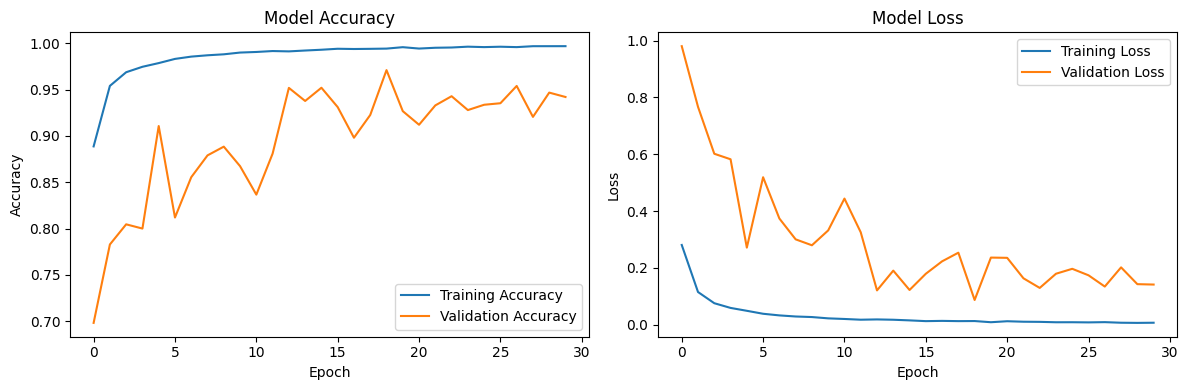

In [9]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()